In [1]:
%load_ext autoreload
%autoreload 2
import torch
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
from Model.dataloader import TranscriptionDataset, collate_fn
from Model.encoder_net import EncoderNet
from Model.decoder_net import DecoderNet
from train import train_transcriber, pre_train_encoder
print(torch.__version__)
from tqdm import tqdm_notebook as tqdm


/Users/likhuva/anaconda2/envs/cs231n/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


0.4.0


In [2]:
# torch.backends.cudnn.enabled = False

### 1. We now Train the Encoder-Decoder Model
> * First we pre-train the encoder on a binary classification task. 
> * Good performance on this task is a good indicator that the encoder is modelling the distribution of the underlying data properly -- This is crucial for the correct functioning of 
our system

#### a) Pre-Trin Encoder
---

In [5]:
def pre_train_encoder_network():
    '''
    We pretrain the encoder to solve be able to classify an image as either
    Ingridients or Nutrition_Facts. An encoder that is able to do this is a good starting
    point for the transcription task.
    '''
    IMAGE_DIR = '../Data/FullData/Cropped_Images/'
    ANNOTATION_PATH = '../Data/FullData/Transcriptions/annotations.npy'
    DATA_PATH = '../Data/FullData/train_dev_test.npy'
    WORD_VEC_PATH = '../Data/FullData/Transcriptions/nutrition_vectors.npy'
    INDEX_TO_TERM_PATH = '../Data/FullData/Transcriptions/index_term_dict.npy'
    TERM_TO_INDEX_PATH = '../Data/FullData/Transcriptions/term_index_dict.npy'
    PATH_TO_MEAN_IMAGE = '../Data/FullData/512_512_mean.npy'
    debug = not torch.cuda.is_available()
    train_dataset = TranscriptionDataset(
        IMAGE_DIR, ANNOTATION_PATH, DATA_PATH, WORD_VEC_PATH,
        PATH_TO_MEAN_IMAGE, debug=debug, split='train'
    )
    train_loader = DataLoader( 
        train_dataset, batch_size=45, shuffle=True,
        num_workers=16, collate_fn=collate_fn
    )
    dev_dataset = TranscriptionDataset(
        IMAGE_DIR, ANNOTATION_PATH, DATA_PATH, WORD_VEC_PATH,
        PATH_TO_MEAN_IMAGE, debug=debug, split='dev',
    )
    dev_loader = DataLoader(
        dev_dataset, batch_size=45, shuffle=True, 
        num_workers=16, collate_fn=collate_fn
    )
    config = {
        'keep_prob': 0.995
    }
    learning_rate = 0.5e-3
    
    encoder = EncoderNet(config_params=config)
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, encoder.parameters()), 
        lr=learning_rate, weight_decay=0.005
    )
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, [5, 10, 20, 30, 40, 50, 100, 150], gamma=0.5
    )
    return pre_train_encoder(
        encoder, optimizer, train_loader, dev_loader, scheduler=scheduler,
        epochs=5, restore=True, save=False
    )

In [6]:
# losses, accuracies = pre_train_encoder_network()

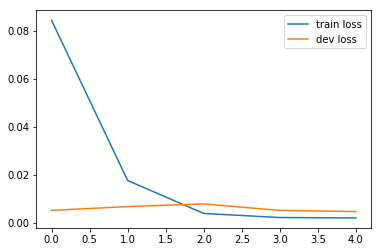

In [6]:
plt.plot(losses[0], label='train loss'); plt.plot(losses[1], label='dev loss')
plt.legend()

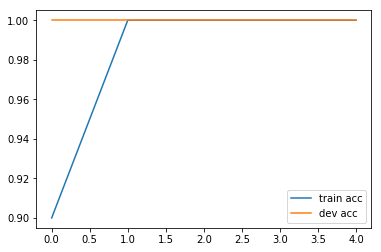

In [7]:
plt.plot(accuracies[0], label='train acc'); plt.plot(accuracies[1], label='dev acc')
plt.legend()

#### b) Train Full E-D model
---

In [10]:
def train_localizer_network(learning_rate=None):
    IMAGE_DIR = '../Data/FullData/Cropped_Images/'
    ANNOTATION_PATH = '../Data/FullData/Transcriptions/annotations.npy'
    DATA_PATH = '../Data/FullData/train_dev_test.npy'
    WORD_VEC_PATH = '../Data/FullData/Transcriptions/nutrition_vectors.npy'
    INDEX_TO_TERM_PATH = '../Data/FullData/Transcriptions/index_term_dict.npy'
    TERM_TO_INDEX_PATH = '../Data/FullData/Transcriptions/term_index_dict.npy'
    PATH_TO_MEAN_IMAGE = '../Data/FullData/512_512_mean.npy' 
    debug = not torch.cuda.is_available()
    
    train_dataset = TranscriptionDataset(
        IMAGE_DIR, ANNOTATION_PATH, DATA_PATH, WORD_VEC_PATH,
        PATH_TO_MEAN_IMAGE, debug=debug, split='train'
    )
    train_loader = DataLoader( 
        train_dataset, batch_size=40, shuffle=True,
        num_workers=16, collate_fn=collate_fn
    )
    
    dev_dataset = TranscriptionDataset(
        IMAGE_DIR, ANNOTATION_PATH, DATA_PATH, WORD_VEC_PATH,
        PATH_TO_MEAN_IMAGE, debug=debug, split='dev',
    )
    dev_loader = DataLoader(
        dev_dataset, batch_size=40, shuffle=True, 
        num_workers=16, collate_fn=collate_fn
    )
    
    
    config = {
        'keep_prob': 0.9995
    }
    if not learning_rate: learning_rate = 1.5e-3
    
    encoder = EncoderNet(config_params=config)
    word_vectors = train_dataset.get_word_vectors()
    embed_size = len(word_vectors[0])
    output_size = train_dataset.get_output_size()
    decoder = DecoderNet(word_vectors, output_size, embed_size)
    
    parameters = list(encoder.parameters()) + list(decoder.parameters())
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, parameters), 
        lr=learning_rate, weight_decay=0.0005
    )
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, [50, 70], gamma=0.5
    )
    results = train_transcriber(
        encoder, decoder, optimizer, train_loader, dev_loader,
        train_dataset, dev_dataset, epochs=1, scheduler=None,
        restore=False, save=True
    )
    return results

In [7]:
lrs = [1e-4, 5e-4, 9e-4, 4e-3,]
results = {}
for lr in lrs:
    c_results  = train_localizer_network(learning_rate=lr)
    results[str(lr)] = c_results  

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  5.540200233459473
	 Dev Loss =  5.724699974060059
	 Train BLEU =  0.00081952714
	 Dev BLEU =  0.00081952714


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  4.52141809463501
	 Dev Loss =  5.4096832275390625
	 Train BLEU =  0.00081952714
	 Dev BLEU =  0.00081952714


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  4.038944244384766
	 Dev Loss =  5.1568474769592285
	 Train BLEU =  0.00081952714
	 Dev BLEU =  0.00081952714


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  3.723036766052246
	 Dev Loss =  5.269680976867676
	 Train BLEU =  0.00081952714
	 Dev BLEU =  0.00081952714


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  3.464846134185791
	 Dev Loss =  5.218449115753174
	 Train BLEU =  0.00081952714
	 Dev BLEU =  0.00081952714


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  3.297960042953491
	 Dev Loss =  5.316762447357178
	 Train BLEU =  0.00081952714
	 Dev BLEU =  0.00081952714


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  3.1801865100860596
	 Dev Loss =  5.325986385345459
	 Train BLEU =  0.00081952714
	 Dev BLEU =  0.00081952714


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  3.092872142791748
	 Dev Loss =  5.432315349578857
	 Train BLEU =  0.00081952714
	 Dev BLEU =  0.00081952714


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  3.0246288776397705
	 Dev Loss =  5.534350872039795
	 Train BLEU =  0.00081952714
	 Dev BLEU =  0.00081952714


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  2.964353084564209
	 Dev Loss =  5.615309715270996
	 Train BLEU =  0.00081952714
	 Dev BLEU =  0.00081952714


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  4.14638090133667
	 Dev Loss =  5.254944324493408
	 Train BLEU =  0.00081952714
	 Dev BLEU =  0.00081952714


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  3.2227141857147217
	 Dev Loss =  5.7627482414245605
	 Train BLEU =  0.00081952714
	 Dev BLEU =  0.00081952714


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  2.969182252883911
	 Dev Loss =  6.079099178314209
	 Train BLEU =  0.00081952714
	 Dev BLEU =  0.0008970573


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  2.8049943447113037
	 Dev Loss =  6.311356067657471
	 Train BLEU =  0.006660686
	 Dev BLEU =  0.001384351


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  2.6554572582244873
	 Dev Loss =  6.4282965660095215
	 Train BLEU =  0.0056426474
	 Dev BLEU =  0.0013068209


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  2.516801595687866
	 Dev Loss =  6.277305603027344
	 Train BLEU =  0.0018716448
	 Dev BLEU =  0.0017165844


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  2.428826332092285
	 Dev Loss =  5.8182549476623535
	 Train BLEU =  0.0014618812
	 Dev BLEU =  0.0025395653


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  2.301713705062866
	 Dev Loss =  6.540718078613281
	 Train BLEU =  0.0019491749
	 Dev BLEU =  0.0025878258


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  2.2364156246185303
	 Dev Loss =  6.697851657867432
	 Train BLEU =  0.004589038
	 Dev BLEU =  0.0027148123


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  2.162667989730835
	 Dev Loss =  6.706361293792725
	 Train BLEU =  0.004441548
	 Dev BLEU =  0.0029724534


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  3.995230197906494
	 Dev Loss =  5.601942539215088
	 Train BLEU =  0.00097458746
	 Dev BLEU =  0.0023284256


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  3.50323486328125
	 Dev Loss =  6.443194389343262
	 Train BLEU =  0.00081952714
	 Dev BLEU =  0.00081952714


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  3.1289453506469727
	 Dev Loss =  6.331419944763184
	 Train BLEU =  0.00081952714
	 Dev BLEU =  0.00081952714


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  2.9045193195343018
	 Dev Loss =  6.453918933868408
	 Train BLEU =  0.0012292907
	 Dev BLEU =  0.00081952714


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  2.7510650157928467
	 Dev Loss =  6.645902156829834
	 Train BLEU =  0.001384351
	 Dev BLEU =  0.001384351


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  2.626208543777466
	 Dev Loss =  6.764901638031006
	 Train BLEU =  0.0052686324
	 Dev BLEU =  0.0023617228


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  2.5194528102874756
	 Dev Loss =  6.897619247436523
	 Train BLEU =  0.0060969307
	 Dev BLEU =  0.0017941146


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  2.426564931869507
	 Dev Loss =  7.00051736831665
	 Train BLEU =  0.0056426474
	 Dev BLEU =  0.0017941146


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  2.4009058475494385
	 Dev Loss =  7.133092880249023
	 Train BLEU =  0.00408493
	 Dev BLEU =  0.0017941146


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  2.3369321823120117
	 Dev Loss =  7.298819541931152
	 Train BLEU =  0.0052686324
	 Dev BLEU =  0.0017941146


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  7.5039849281311035
	 Dev Loss =  9.979863166809082
	 Train BLEU =  0.0018411318
	 Dev BLEU =  0.0


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  3.363565683364868
	 Dev Loss =  9.866616249084473
	 Train BLEU =  0.0012292907
	 Dev BLEU =  0.0


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  3.172255277633667
	 Dev Loss =  11.089956283569336
	 Train BLEU =  0.0012292907
	 Dev BLEU =  0.00081952714


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  3.1252925395965576
	 Dev Loss =  14.994451522827148
	 Train BLEU =  0.0012292907
	 Dev BLEU =  0.00081952714


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  3.0351576805114746
	 Dev Loss =  15.975752830505371
	 Train BLEU =  0.0012292907
	 Dev BLEU =  0.00081952714


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  2.931489944458008
	 Dev Loss =  16.517580032348633
	 Train BLEU =  0.0012292907
	 Dev BLEU =  0.00081952714


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  2.834756851196289
	 Dev Loss =  16.723569869995117
	 Train BLEU =  0.0012292907
	 Dev BLEU =  0.00081952714


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  2.9002437591552734
	 Dev Loss =  16.432775497436523
	 Train BLEU =  0.001384351
	 Dev BLEU =  0.0


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  2.77461576461792
	 Dev Loss =  10.928999900817871
	 Train BLEU =  0.001384351
	 Dev BLEU =  0.00040976357


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  2.8092281818389893
	 Dev Loss =  7.203765392303467
	 Train BLEU =  0.004858869
	 Dev BLEU =  0.00097458746


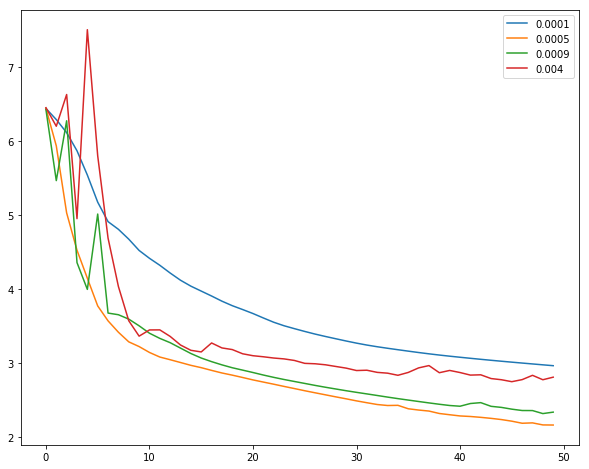

In [8]:
for k, v in results.items():
    plt.plot(v[0], label=k)
plt.legend()

In [11]:
r = train_localizer_network(learning_rate=5e-4)

622
622


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

In [4]:
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

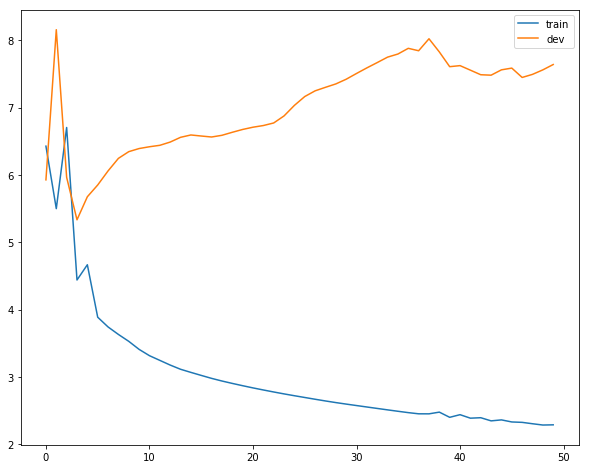

In [5]:
train_losses, dev_losses, train_bleu, dev_bleu = r
plt.plot(train_losses, label='train')
plt.plot(dev_losses, label='dev')
# import numpy as np
# np.save('results', r)
plt.legend()

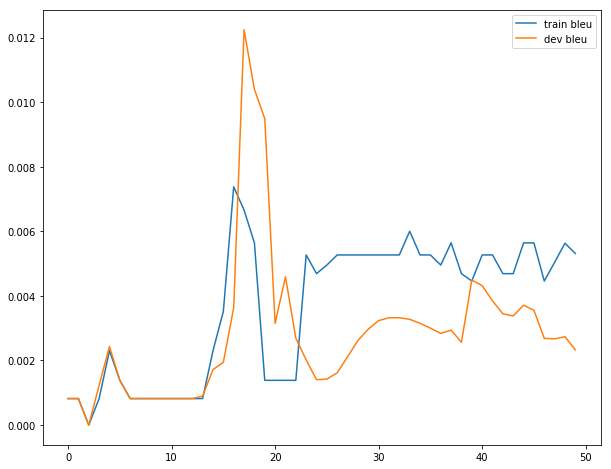

In [6]:
plt.plot(train_bleu, label='train bleu')
plt.plot(dev_bleu, label='dev bleu')
plt.legend()

In [ ]:
def ensure_all_data_is_available():
    import numpy as np
    data_path = '../Data/FullData/train_dev_test.npy'
    ANNOTATION_PATH = '../Data/FullData/Transcriptions/annotations.npy'
    annotations = np.load(ANNOTATION_PATH).item()
    images = (
            np.load(data_path).item()['train'] + np.load(data_path).item()['dev'] + 
            np.load(data_path).item()['test']
    )
    bad = []
    for img in tqdm(images):
        num = img[:img.rfind('_')]
        nut = '1_' + num; ingr = '0_'+num
        if nut not in annotations or ingr not in annotations:
            bad.append(num)
    print(set(bad))

In [8]:
a = torch.ones(2, 4, 10)
b = torch.zeros(2, 1, 12)
c = b.expand(2, 4, 12)
c.shape

torch.Size([2, 4, 12])

In [11]:
d = torch.cat((a, c), -1)
d.shape

torch.Size([2, 4, 22])